In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

# Pre-processing

In [2]:
class SHM_Dataset(Dataset):
    """ Prepare dataset for pytorch
        Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """

    def __init__(self, case, data_file):
        self.case = case
        self.data_file = Path(data_file)
        self.data_df = pd.read_json(self.data_file, dtype=np.array)
        self.data = self.data_df.stack()
        self.labels = pd.DataFrame([self.case,]*self.data_df.shape[0]*self.data_df.shape[1])
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        label = np.array(self.labels.iloc[index])
        feature = np.array(self.data.iloc[index])
        # print(f"feature: {feature.shape}, label: {label.shape}")
        return feature, label

shmDS = SHM_Dataset(1, "~/Codes/homework/data/SHM/shm01s.json")
print("There is", len(shmDS), "samples in the given dataset")

There is 2992 samples in the given dataset


Let's have a look on a single sample:

Feature batch shape: torch.Size([64, 1, 8, 16])
Labels batch shape: torch.Size([64, 1])


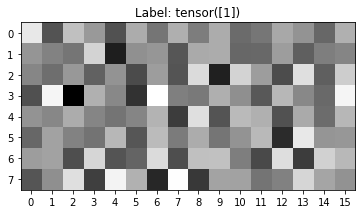

In [3]:
train_loader = DataLoader(shmDS, batch_size=64, shuffle=True) # split samples into mini-batches and reshuffle the data to reduce overfitting
test_loader = DataLoader(shmDS, batch_size=64, shuffle=False)

train_features, train_labels = next(iter(train_loader))
train_features = train_features.unsqueeze(dim=1)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
fig, axis = plt.subplots()
axis.imshow(img, cmap="gray")
axis.set(title=f"Label: {label}", xticks=range(16), yticks=range(8))
plt.show()


# Build the neural network

## CNN Model

In [4]:
# Two-layer convolution
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Quick build with sequence tools
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(2 * 4 * 32, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)  # reshape
        out = self.fc(out)
        return out

cnn = CNN()

## Loss and Optimizer

In [5]:
# Hyper Parameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Train the model

In [6]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        images = images.unsqueeze(dim=1)
        images = images.float()
        labels = Variable(labels)
        # print(type(images), images)
        # print(type(labels), labels)
        # print("[ OK ] at this step") 

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        # loss = loss_func(outputs, labels)
        loss = loss_func(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item()))

# Test the model

In [7]:
cnn.eval()  # Change to test form, application scenarios such as: dropout
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    images = images.unsqueeze(dim=1)
    images = images.float()
    labels = Variable(labels)

    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.data).sum()

print(' Test Accuracy: %d %%' % (100 * correct / total))

# Save the Trained Model
# torch.save(cnn.state_dict(), 'cnn.pkl')

 Test Accuracy: 0 %
